In [1]:
import json
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


from skimage.metrics import peak_signal_noise_ratio


# put ticks inside the plot
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# put ticks on the up and right side also
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
# grid in very light grey
plt.rcParams['grid.alpha'] = 0.2
# put a grid by default
plt.rcParams['axes.grid'] = True


def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False
def isint(value):
    try:
        int(value)
        return True
    except ValueError:
        return False

def read_params(params_file):
    with open(params_file, "r") as f:
        l = []
        for line in f:
            l.append(line.rstrip())
        d = {}
        for ii, line in enumerate(l):
            params_line = line.split("--")
            path = params_line.pop(0)
            path = path.split('	')[0]
            params = {}
            for jj, param in enumerate(params_line):
                param = param.split(" ")
                if param[-1]=='':
                    param = param[:-1]
                for ii in range(len(param)):
                    if isfloat(param[ii]): param[ii] = float(param[ii])
                    elif isint(param[ii]): param[ii] = int(param[ii])
                params[param[0]] = param[1:] if len(param)>2 else param[1]
            d[path] = params
        return d

def parse_logs(path, keyword):
    with open(path, "r") as f:
        l = []
        for line in f:
            l.append(line.rstrip())
        d = {}
        for ii, line in enumerate(l):
            if keyword in line:
                d[ii] = json.loads(line)
        return d

def filter_paths(params, filters):
    paths = list(params.keys())
    paths_copy = list(params.keys())
    iis = []
    for ii, path in enumerate(paths_copy):
        param = params[path]
        for k_filter, v_filter in filters.items():
            if k_filter in param:
                if param[k_filter] not in v_filter:
                    paths.remove(path)
                    break
    return paths

def sweepable_params(params):
    sweepable = {}
    for path, param in params.items():
        for k, v in param.items():
            if k not in sweepable:
                sweepable[k] = []
            if v not in sweepable[k]:
                sweepable[k].append(v)
    sweepable = {k: v for k, v in sweepable.items() if len(v)>1}
    sweepable = {k: v for k, v in sweepable.items() if 'master_port' not in k.lower()}
    return sweepable

def visu_diff(img_ori, img_comp, title=None, figsize=(20,30), crop=None, hori=True):
    mpl.rcParams['axes.grid'] = False

    plt.figure(figsize=figsize)
    
    img_ori_ar = np.asarray(img_ori)
    img_comp_ar = np.asarray(img_comp)

    # Crop the images if crop parameter is provided
    if crop is not None:
        if isinstance(crop, int):
            img_ori_ar = img_ori_ar[:crop, :crop]
            img_comp_ar = img_comp_ar[:crop, :crop]
        elif isinstance(crop, tuple):
            img_ori_ar = img_ori_ar[:crop[0], :crop[1]]
            img_comp_ar = img_comp_ar[:crop[0], :crop[1]]

    if hori:
        plt.subplot(1, 3, 1)    
    else:
        plt.subplot(3, 1, 1)
    plt.imshow(img_ori_ar)
    plt.title('Image 1')

    if hori:
        plt.subplot(1, 3, 2)    
    else:
        plt.subplot(3, 1, 2)
    plt.imshow(img_comp_ar)
    plt.title('Image 2')

    diff = img_comp_ar.astype(int) - img_ori_ar.astype(int)
    psnr = peak_signal_noise_ratio(img_ori_ar, img_comp_ar)
    print(f'PSNR: {psnr}')
    print(f'Linf: {np.max(np.abs(diff))}')
    
    # normalize diff
    diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
    diff = np.abs(diff - 0.5)
    # diff = np.linalg.norm(diff, ord=1, axis=2)
    # diff = diff * (1.0/diff.max())
    # diff = np.abs(diff)
    # diff = diff * (5/255)
    if hori:
        plt.subplot(1, 3, 3)    
    else:
        plt.subplot(3, 1, 3)
    # print(diff.shape)
    # diff[..., 1] = 0
    # diff[..., 0] = 0
    plt.imshow(diff)
    plt.title('Difference')

    title += f' - PSNR: {psnr:.2f}'
    if title is not None:
        plt.suptitle(title, fontsize=10)

    plt.tight_layout()
    plt.show()

    mpl.rcParams['axes.grid'] = True

    return diff

# plot
def plot_measure(measures):
    fig, axes = plt.subplots(nrows=1, ncols=len(measures), figsize=(3*len(measures), 3))
    for ii, path in enumerate(paths):
        df = dfs[path]
        param = params[path]

        for jj, measure in enumerate(measures):
            try:
                ax = axes[jj]
            except:
                ax = axes
            df = df.dropna(subset=[measure])
            ax.plot(df['epoch'][:max_epoch], df[measure][:max_epoch], label=f"{path.replace('_', '')}",alpha=0.9)
            ylabel = measure.replace('_', ' ').capitalize()
            if 'acc' in ylabel: 
                ax.set_ylim(0.5, 1.01)
            ax.set_ylabel(ylabel)
            xlabel = 'Epoch'
            ax.set_xlabel(xlabel)
            ax.grid(True)

    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(1.04, -0.1), fontsize=16, ncol=1, fancybox=True, shadow=True)
    plt.show()

# **15 July**

## 0719_segmark_patrn

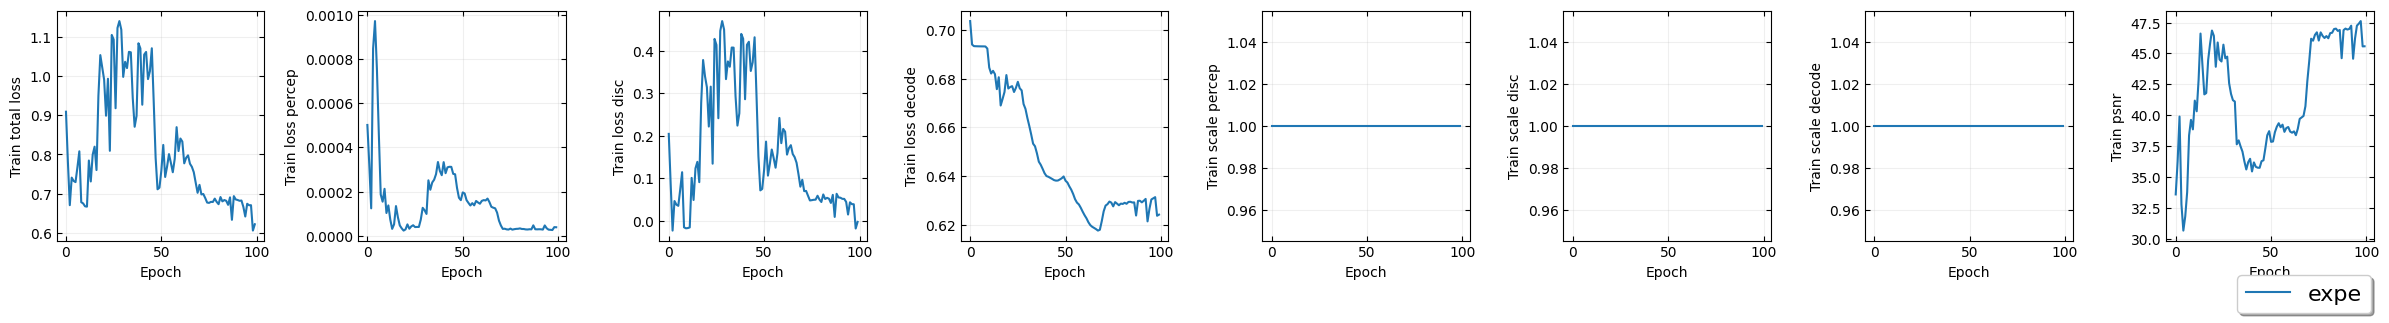

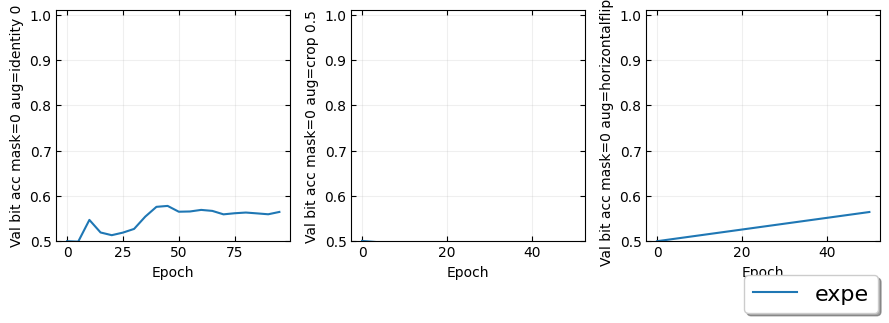

In [12]:
all_exp_dir = "/checkpoint/pfz/2024_logs/hidden_minimal"
# all_exp_dir = "/checkpoint/pfz/2024_logs/hidden_minimal_balanced"
filters = {
}

# load params and filter
params = read_params(os.path.join(all_exp_dir, 'params.txt'))
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f"{k}: {v}")

# load dataframes
dfs = {}
list_scaling = []
for ii, path in enumerate(paths):
    exp_dir = os.path.join(all_exp_dir, path)
    param = params[path]
    try:
        logs = parse_logs(os.path.join(exp_dir, 'log.txt'), '')
        dfs[path] = pd.DataFrame.from_dict(logs).transpose()
    except:
        print(f"{path} is not found")

paths = dfs.keys()
try:
    epoch = max(dfs[path]['epoch'])
except:
    epoch=0
epoch = int(epoch - epoch % 5)
max_epoch = 2000

# 20 different colors
colors = plt.cm.tab20.colors
# colors = [ plt.cm.tab20.colors[2*ii] for ii in range(3) ] + [ plt.cm.tab20.colors[2*ii+1] for ii in range(3) ] 

def remove_outliers(df, measure):
    Q1 = df[measure].quantile(0.25)
    Q3 = df[measure].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[measure] >= lower_bound) & (df[measure] <= upper_bound)]

def plot_measure(measures, title=None):
    if len(measures) > 8:
        ncols = 8
        nrows = (len(measures) + 7) // 8  # Calculate the number of rows needed
    else:
        ncols = len(measures)
        nrows = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for ii, path in enumerate(paths):
        df = dfs[path]
        param = params[path]
        for jj, measure in enumerate(measures):
            try:
                ax = axes[jj]
            except IndexError:
                continue  # Skip if there are more measures than axes available
            df = df.dropna(subset=[measure])
            # df = remove_outliers(df, measure)
            ax.plot(df['epoch'][:max_epoch], df[measure][:max_epoch], 
                    label=f"{path.replace('_', '')}" ,
                    # label=
                    #     f"lambda_i:{param['lambda_i']}, " +
                    #     f"lambda_d:{param['lambda_d']}, " +
                    #     f"embedder:{param['embedder_model']}, " +
                    #     f"scaling_w:{param['scaling_w']}",
                    color=colors[ii],
                    )
                    # label=f"{path.replace('_', '')}")
            ylabel = measure.replace('_', ' ').capitalize()
            if 'acc' in ylabel: 
                ax.set_ylim(0.5, 1.01)
            ax.set_ylabel(ylabel)
            xlabel = 'Epoch'
            ax.set_xlabel(xlabel)
            ax.grid(True)
    if title is not None:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    ax.legend(loc='upper right', bbox_to_anchor=(1.04, -0.1), fontsize=16, ncol=1, fancybox=True, shadow=True)
    plt.show()
    

measures = ['train_total_loss', 'train_loss_percep', 'train_loss_disc', 'train_loss_decode', 'train_scale_percep', 'train_scale_disc', 'train_scale_decode', 'train_psnr']
plot_measure(measures)

measures = ['val_bit_acc_mask=0_aug=identity_0', 'val_bit_acc_mask=0_aug=crop_0.5', 'val_bit_acc_mask=0_aug=horizontalflip_0']
plot_measure(measures)

# augs = ["brightness_0.5", "brightness_1.5", "contrast_0.5", "contrast_1.5", "saturation_0.5", "saturation_1.5", "hue_-0.5", "hue_-0.25", "hue_0.25", "hue_0.5", "jpeg_40", "jpeg_60", "jpeg_80", "gaussianblur_3", "gaussianblur_5", "gaussianblur_9", "gaussianblur_17", "medianfilter_3", "medianfilter_5", "medianfilter_9", "medianfilter_17", "rotate_10", "rotate_30", "rotate_45", "rotate_90", "resize_0.5", "resize_0.75", "crop_0.5", "crop_0.75", "perspective_0.2", "perspective_0.5", "perspective_0.8", "horizontalflip_0"]
# measures = [f"val_bit_acc_mask=1_aug={aug}" for aug in augs]
# plot_measure(measures, title='Validation Bit Accuracy')

# augs = ["brightness_0.5", "brightness_1.5", "contrast_0.5", "contrast_1.5", "saturation_0.5", "saturation_1.5", "hue_-0.5", "hue_-0.25", "hue_0.25", "hue_0.5", "jpeg_40", "jpeg_60", "jpeg_80", "gaussianblur_3", "gaussianblur_5", "gaussianblur_9", "gaussianblur_17", "medianfilter_3", "medianfilter_5", "medianfilter_9", "medianfilter_17", "rotate_10", "rotate_30", "rotate_45", "rotate_90", "resize_0.5", "resize_0.75", "crop_0.5", "crop_0.75", "perspective_0.2", "perspective_0.5", "perspective_0.8", "horizontalflip_0"]
# measures = [f"val_miou_mask=1_aug={aug}" for aug in augs]
# plot_measure(measures, title='Validation IoU')

_lambda_i=0.0_perceptual_loss=pattern0_embedder_model=vae_small
PSNR: 22.175127608040416
Linf: 23


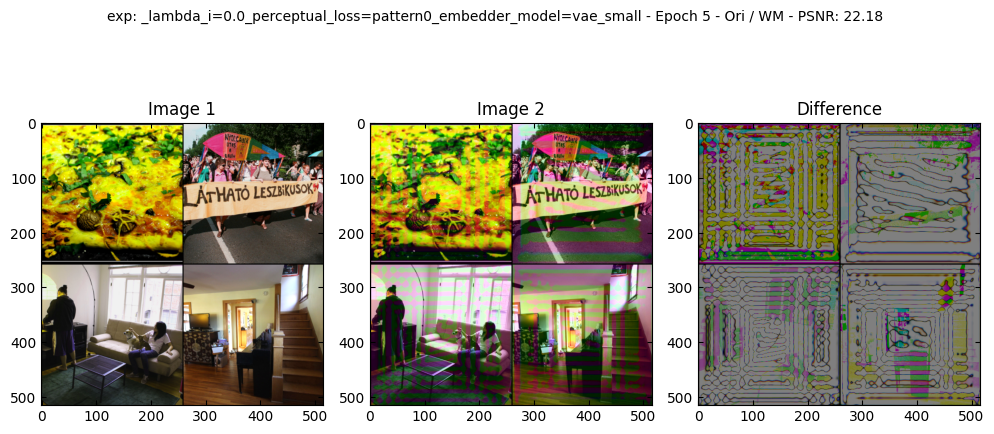

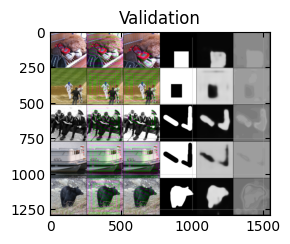

_lambda_i=0.0_perceptual_loss=pattern0_embedder_model=unet_plus_big
PSNR: 23.38313409766721
Linf: 23


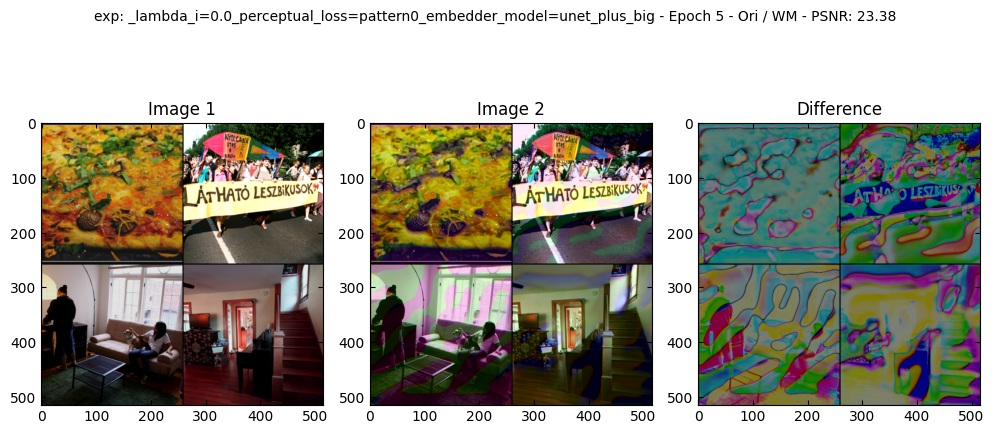

_lambda_i=0.0_perceptual_loss=pattern0_embedder_model=unet_plus_big is not found
_lambda_i=0.0_perceptual_loss=pattern1_embedder_model=vae_small
PSNR: 22.03938234700381
Linf: 23


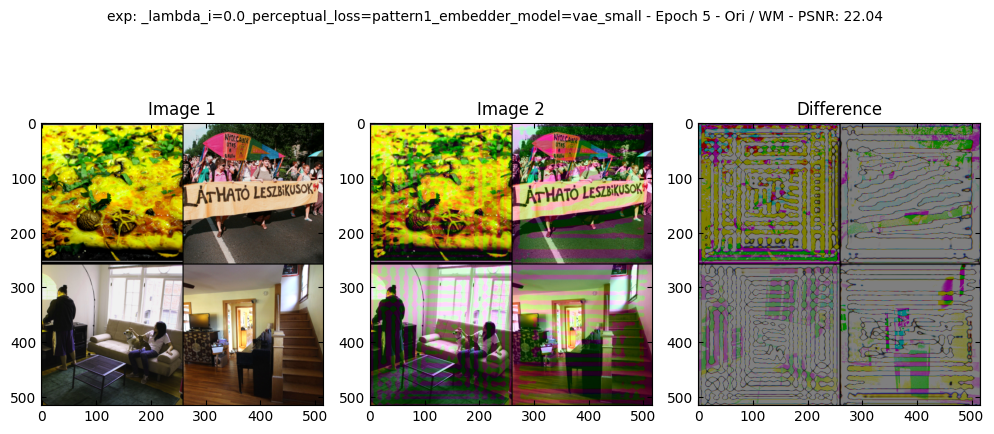

_lambda_i=0.0_perceptual_loss=pattern1_embedder_model=vae_small is not found
_lambda_i=0.0_perceptual_loss=pattern1_embedder_model=unet_plus_big
PSNR: 22.873941404743462
Linf: 23


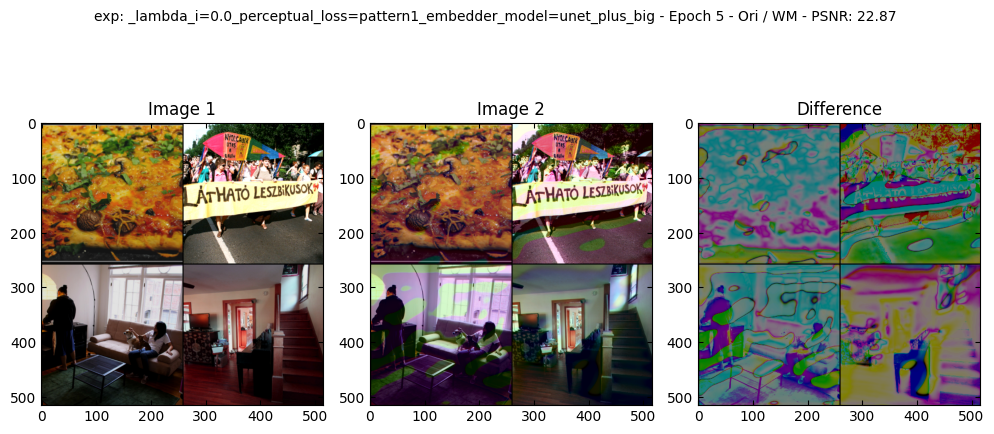

_lambda_i=0.0_perceptual_loss=pattern1_embedder_model=unet_plus_big is not found
_lambda_i=1.0_perceptual_loss=pattern0_embedder_model=vae_small
PSNR: 22.276127708398946
Linf: 23


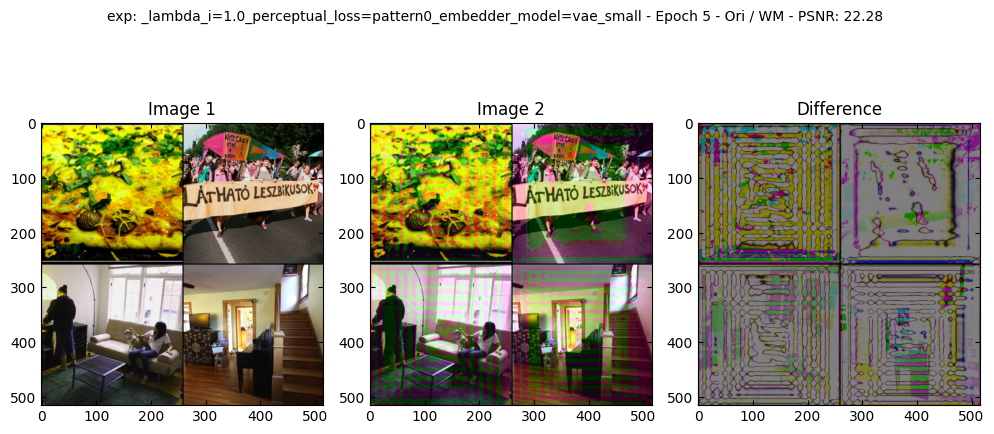

_lambda_i=1.0_perceptual_loss=pattern0_embedder_model=vae_small is not found
_lambda_i=1.0_perceptual_loss=pattern0_embedder_model=unet_plus_big
PSNR: 24.007811566975906
Linf: 23


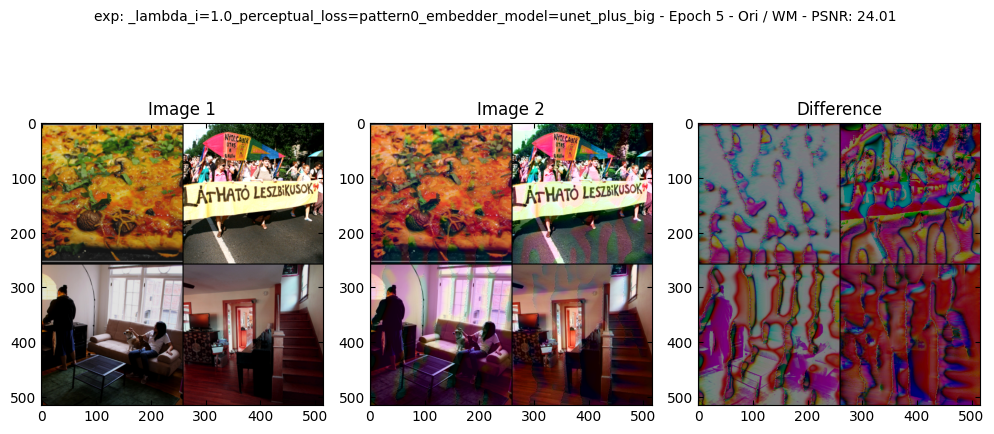

_lambda_i=1.0_perceptual_loss=pattern0_embedder_model=unet_plus_big is not found
_lambda_i=1.0_perceptual_loss=pattern1_embedder_model=vae_small
PSNR: 28.627785894339883
Linf: 23


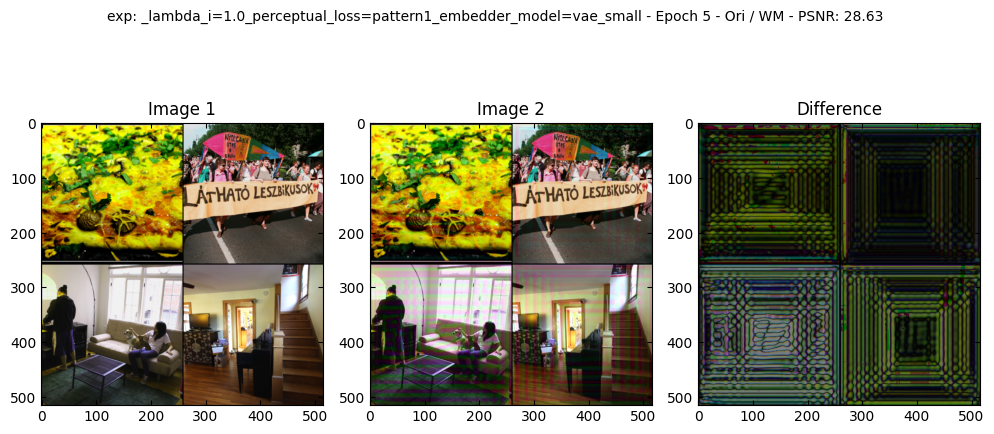

_lambda_i=1.0_perceptual_loss=pattern1_embedder_model=vae_small is not found
_lambda_i=1.0_perceptual_loss=pattern1_embedder_model=unet_plus_big
PSNR: 32.383886527736905
Linf: 22


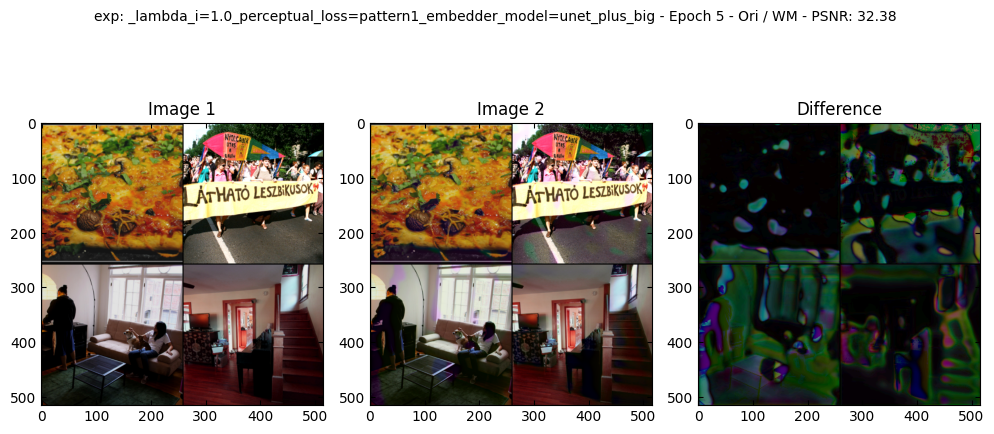

_lambda_i=1.0_perceptual_loss=pattern1_embedder_model=unet_plus_big is not found
_lambda_i=2.0_perceptual_loss=pattern0_embedder_model=vae_small
PSNR: 22.534977703061422
Linf: 23


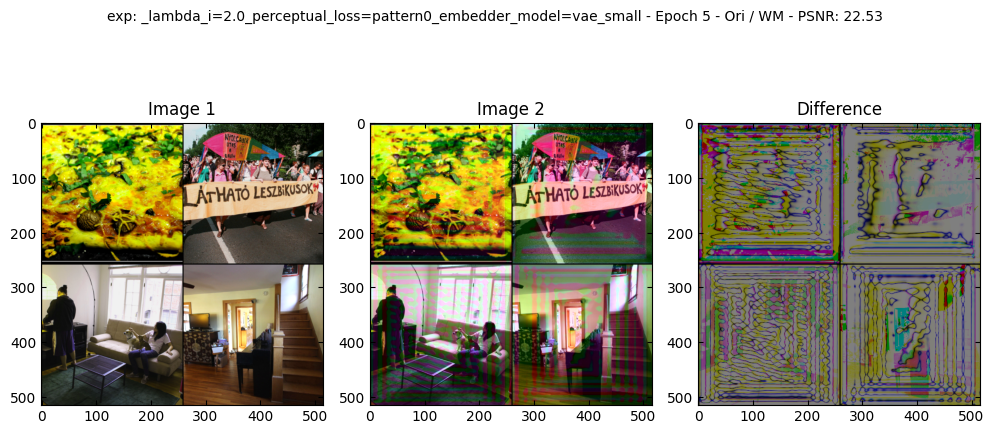

_lambda_i=2.0_perceptual_loss=pattern0_embedder_model=vae_small is not found
_lambda_i=2.0_perceptual_loss=pattern0_embedder_model=unet_plus_big
PSNR: 23.70615297615334
Linf: 23


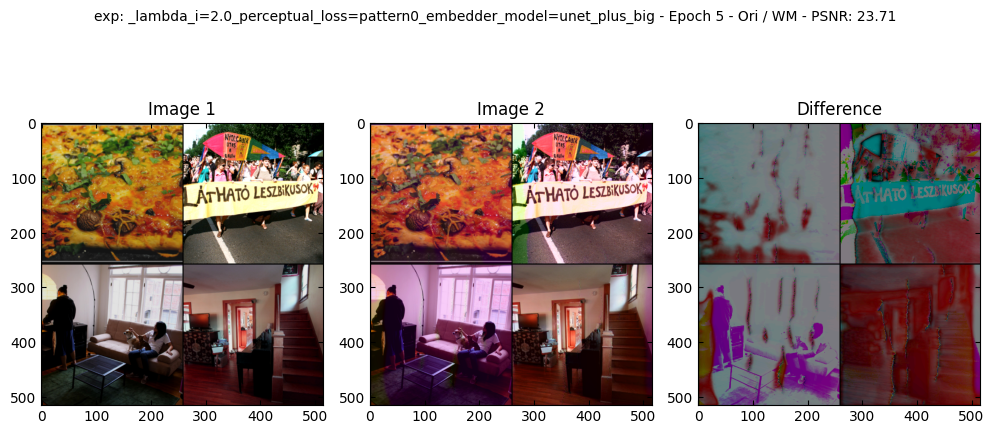

_lambda_i=2.0_perceptual_loss=pattern0_embedder_model=unet_plus_big is not found
_lambda_i=2.0_perceptual_loss=pattern1_embedder_model=vae_small
PSNR: 36.82178007231319
Linf: 22


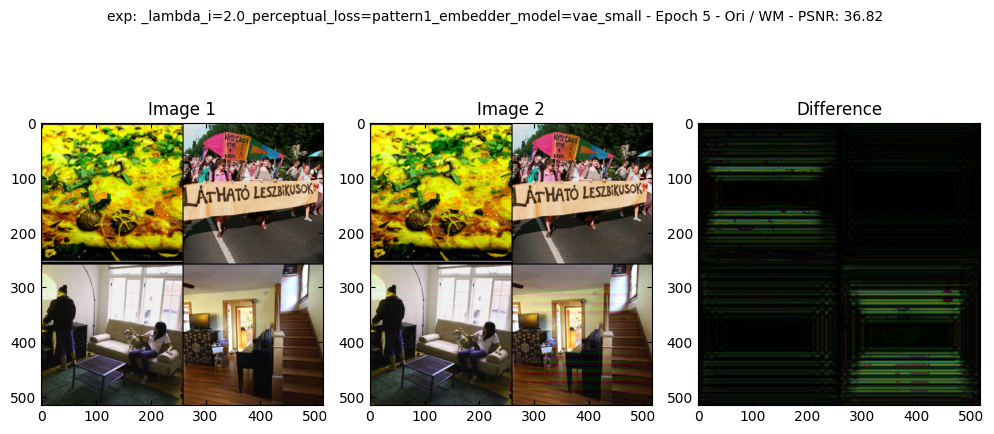

_lambda_i=2.0_perceptual_loss=pattern1_embedder_model=vae_small is not found
_lambda_i=2.0_perceptual_loss=pattern1_embedder_model=unet_plus_big
PSNR: 35.66686789554864
Linf: 22


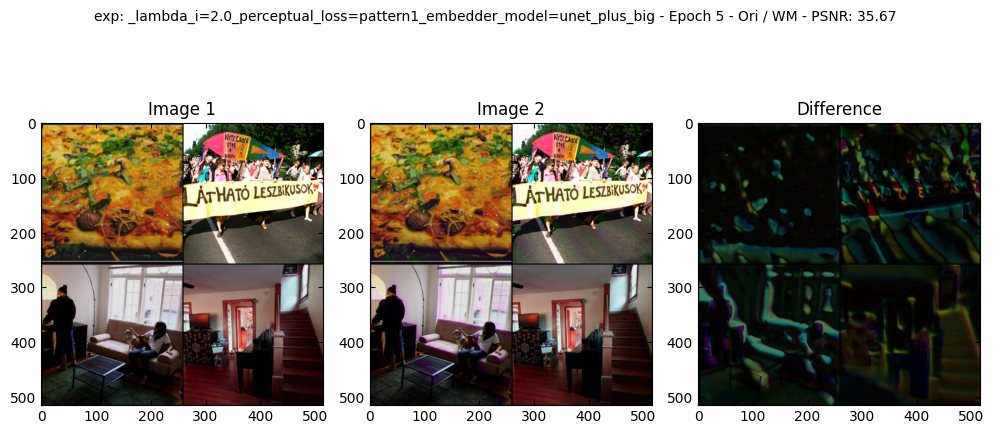

_lambda_i=2.0_perceptual_loss=pattern1_embedder_model=unet_plus_big is not found


In [26]:
epoch = 5
figsize = (10, 5)
for exp_key in paths:
    print(exp_key)
    try:
        path_img_o = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_0_ori.png"
        path_img_w = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_1_w.png"
        path_img_aug = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_3_aug.png"
        path_mask = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_4_mask.png"
        path_pred = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_5_pred.png"
        path_val = f"{all_exp_dir}/{exp_key}/{epoch:03d}_val_full.png"

        img_o = Image.open(path_img_o)
        img_w = Image.open(path_img_w)
        img_aug = Image.open(path_img_aug)
        crop_size = (256 * 2 + 4, 256 * 2 + 4)
        visu_diff(img_o, img_w, title=f"exp: {exp_key} - Epoch {epoch} - Ori / WM", figsize=figsize, hori=True, crop=crop_size)
        
        # mask = Image.open(path_mask)
        # pred = Image.open(path_pred) 
        # # threshold pred 
        # pred = np.array(pred)
        # pred[pred<128] = 0
        # pred[pred>=128] = 255
        # pred = Image.fromarray(pred)
        # visu_diff(mask, pred, title=f"exp: {exp_key} - Epoch {epoch} - Mask / Pred", figsize=figsize, hori=True, crop=crop_size)
        
        val = Image.open(path_val)
        plt.figure(figsize=(3, 3))
        plt.imshow(val)
        plt.title('Validation')
        plt.tight_layout()
        plt.show()
    except:
        print(f"{exp_key} is not found")
        continue